In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.modeling.img_exploration_env import ImageExplorationEnv, RewardFunction
from uav_active_sensing.modeling.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.modeling.ppo import PPOAgent, run_ppo_in_custom_env
from uav_active_sensing.plots import visualize_reconstruction

import torch
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor


In [17]:
TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def tiny_imagenet_collate_fn(batch):
    processed_batch = [
        image[0]["pixel_values"].to(DEVICE)
        for image in batch
    ]

    return torch.cat(processed_batch, dim=0)


image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=image_processor
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=image_processor
)
dataloader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn)  # Currently only supports batch size of 1

custom_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(custom_model)

# TODO: Add config that avoids movement in z (fixed kernel size)
env_config = {
    "device": DEVICE,
    "img": None,
    "reward_function": reward_function,
    "patch_size": 16,
    "max_steps": 20,
    "interval_reward_assignment": 10,
    "v_max_x": 10,
    "v_max_y": 10,
    "v_max_z": 0,
}

### RL trainig with epoch interface

In [19]:
env_config.update({"img": "img"})

In [20]:
env_config

{'device': 'cpu',
 'img': 'img',
 'reward_function': <uav_active_sensing.modeling.img_exploration_env.RewardFunction at 0x79351db2acc0>,
 'patch_size': 16,
 'max_steps': 20,
 'interval_reward_assignment': 10,
 'v_max_x': 10,
 'v_max_y': 10,
 'v_max_z': 0}

In [23]:

# TODO: Repeat for many epochs until convergence


# First half of the epoch. Train RL agent(s) in env instantiated with each batch

total_reward = 0
for i, img in enumerate(dataloader):
    terminated = False
    env_config["img"] = img
    env = ImageExplorationEnv(env_config)
    observation, info = env.reset()  # reset loads a new batch into the environment
    # Episode loop
    # Rollout sample
    while not terminated:        
        # action = ppo_algo.compute_single_action(observation)
        action = env.action_space.sample()

        next_observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward.detach().numpy()

        if env.step_count % env.interval_reward_assignment == 0:
            print(f"Reward={total_reward}")
            total_reward = 0

        observation = next_observation
    # TODO: Use rollout to perform a gradient update
    # TODO: Store batch sampled images paired with actual images.
    # We need a dataloader that returns pairs of images for MAE fine tuning during the second half of the epoch

    if i == 2:
        break

# TODO: Second half of the epoch. Train MAE here with pairs of batches of sampled and complete images

env.close()

Reward=0.3747190237045288
Reward=0.3621007204055786
Reward=0.42148175835609436
Reward=0.46459323167800903
Reward=0.40518373250961304
Reward=0.39660805463790894


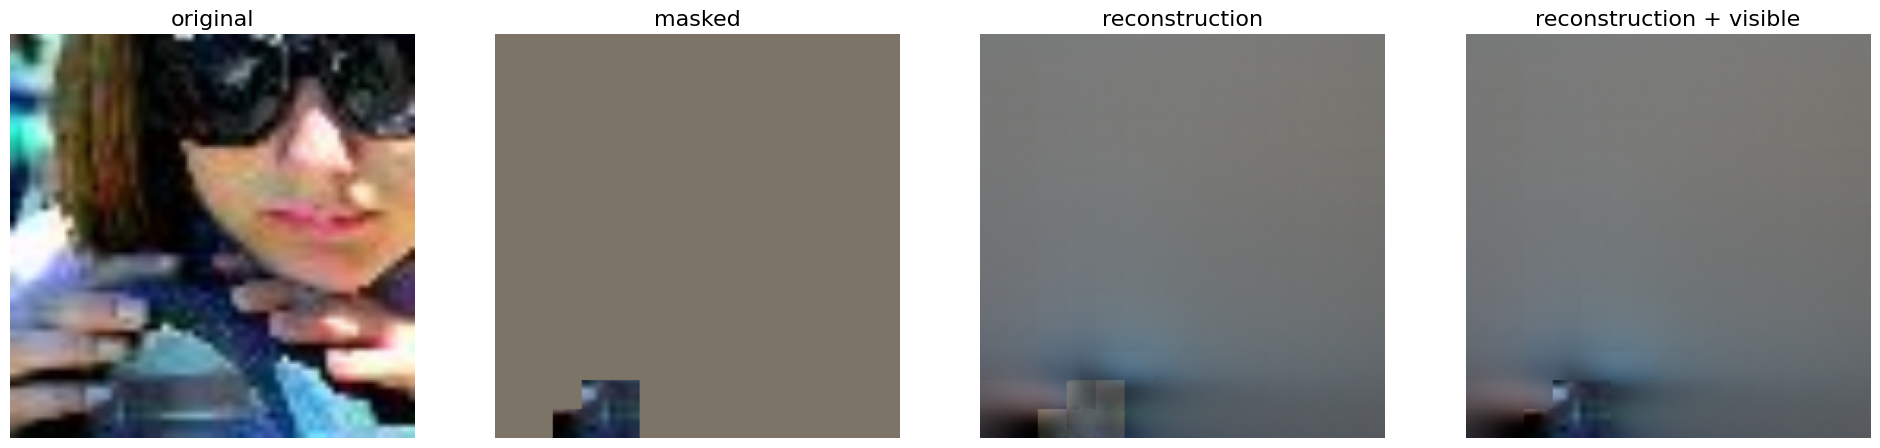

In [24]:
visualize_reconstruction(env.img[0].unsqueeze(0), env.sampled_img[0].unsqueeze(0), custom_model)